In [1]:
import pandas as pd

1. load data

In [2]:
df = pd.read_csv('Consumer_Complaints.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2. Discard the rows where consumer complaint narrative is blank. How many rows does this yield?


In [3]:
df_dropped = df[df['Consumer complaint narrative'].notna()]
#print ("Dropped %d rows, %d rows yield",le#n(df)-len(df_dropped), len(df_dropped))
print ("Dropped " + str(len(df)-len(df_dropped))+" rows, " + 
       str(len(df_dropped))+" rows yield")

Dropped 852076 rows, 367439 rows yield


3. Draw a histogram of number of complaints by company name. What can you conclude about which institutions are causing the most complaints?

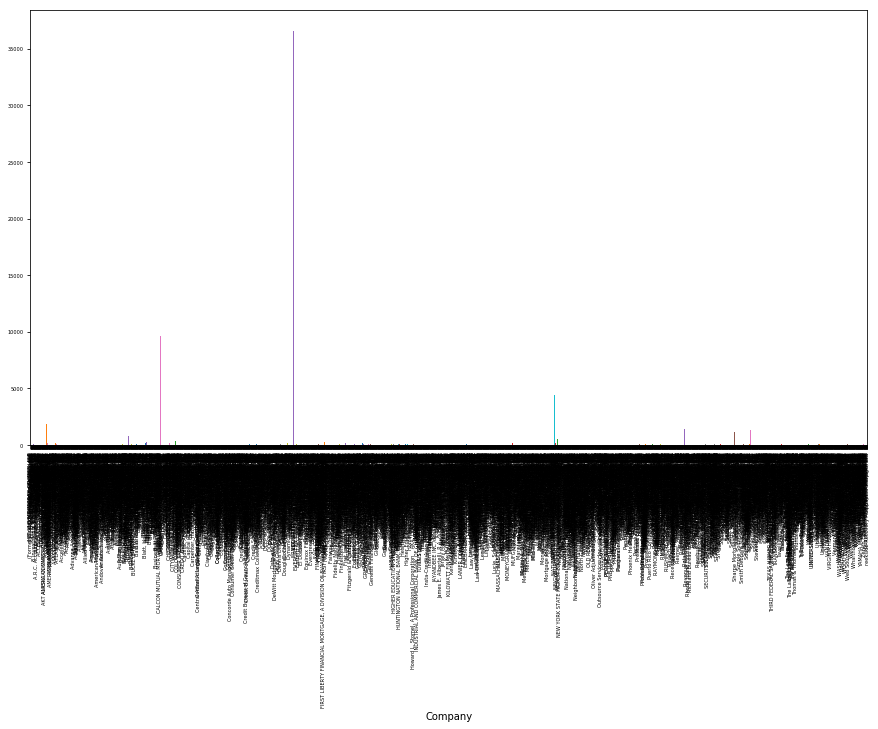

In [5]:
%matplotlib inline
df_dropped.groupby('Company')['Complaint ID'].count().plot(figsize=(15,8),
                                                           kind = 'bar',fontsize = 5)

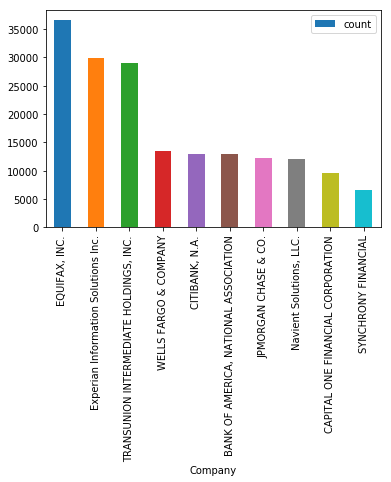

In [6]:
# Only look at companies with top complaints
df_dropped.groupby('Company')['Complaint ID'].count()\
.reset_index(name = 'count').sort_values('count',ascending = False)[:10].plot(
    kind='bar', x = 'Company',y='count')

If we plot all companies on the bar chart, we can see the companies with most complaints have far more complaints than others. Only 1 company has more than 35k complaints, and the second most is around 30k. In total only 7~8 companies have significant size of bars in the first graph. It's also hard to tell which one is associating with the most complaints. 
In the second bar chart which only plots the companies with top 10 most complaints, we can see which companies are causing the most complaints. Interestingly, top 3 companies are all credit score reporting companies, followed by banks and then personal financing companies. Since there are only several credit score reporting companies, it makes sense that they received the most complaints as they have far more interactions with customers than banks and personal financing companies.

In [7]:
df_dropped.groupby('Company')['Complaint ID'].count()\
.reset_index(name = 'count').sort_values('count',ascending = False)[:10]

,Company,count
1280,"EQUIFAX, INC.",36584
1377,Experian Information Solutions Inc.,29964
3631,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",29056
3948,WELLS FARGO & COMPANY,13561
691,"CITIBANK, N.A.",13005
462,"BANK OF AMERICA, NATIONAL ASSOCIATION",12909
1991,JPMORGAN CHASE & CO.,12315
2655,"Navient Solutions, LLC.",12053
633,CAPITAL ONE FINANCIAL CORPORATION,9616
3365,SYNCHRONY FINANCIAL,6654


4. Create a model to predict the product based on the consumer complaint narrative. What modeling techniques could you use? How accurate are your predictions for each field, and how did you evaluate this?

Since this is a supervised multiclass classification task, we could use logistic regression. Below I first coded product into numerica values, lemmatized and filtered out stopwords in each complaint and added each to a list of string.
Next, I normalized the narratives through TfidfVectorizer with max_df = 0.7 and min_df = 5 to weigh each word in the corpus. This gave me a 367439 * 16409 matrix. I splitted the matrix with the corresponding labels and trained the logistic regression model and the average accuracy is 71%. 
(I tried using PCA to bring down the dimension before training, but the accuracy decreased possibly due to the loss of information, so I chose to fit the whole matrix.)
To evaluate the accuracy at each field, I stored the result of the confusion matrix in a dataframe and illustrated with a heatmap. 

From heatmap, we can see many fields are predicted really well with a high number along the diagonal line, such as 'debt collection' and 'credit card reporting, credit card repair services, or other personal consumer reports'. There are some fields with higher confusion due to misleading product labeling. Some fields are subsets of another fields or are highly related. For example, 'credit card reporting' and 'credit card reporting, credit card repair services, or other personal consumer reports' are catagorized as 2 products, but in real life it's very likely customers are complainning about the same thing. Similar situations can be found between 'prepaid card' and 'credit card or prepaid card', 'student loan' and 'debt collection','money transfer' and 'money transfer and virtual currency'. Prediction accurary can be improved if we modify the product categories and make them more dinguishable to each other.

Additionally, the prediction accuracy is really low for products ('virtual currency','other financial services' for example) that are not much represented in the test data. By breaking down the whole dataset by product, we can for some products there are much fewer complaints. This means we don't have enough information to train our model to predict accurately on this fields.



In [52]:
# uncomment to run the full data
df1 = df_dropped
# uncomment to run sample data
#df1 = df_dropped.sample(10000)

In [53]:
df1['Product'] = df1['Product'].astype('category')
df1['Product_ID'] = df1['Product'].factorize()[0]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
narratives = df1['Consumer complaint narrative'].tolist()
products = df1['Product'].tolist()
labels = df1['Product_ID'].tolist()

In [55]:
#lemmatization
import spacy
import re
nlp = spacy.load('en',disable=['ner', 'parser', 'tagger'])

lemmatized_narratives = []
for n in narratives:
    parsed_text = nlp(n)
    lemma_string = ''
    for token in parsed_text:
        lemma = token.lemma_.lower()
        if (re.match('[a-zA-Z]+$', lemma)) and not (nlp.vocab[lemma].is_stop):
            lemma_string += lemma+' '
    lemmatized_narratives.append(lemma_string)

In [57]:
# normalize the lemmas
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(norm = 'l2', ngram_range(1,2),max_df = 0.7,min_df = 5,sublinear_tf = True)
X = vectorizer.fit_transform(lemmatized_narratives).toarray()
X.shape
# bring down the dimension
#from sklearn.manifold import TSNE
#tsne = TSNE(n_components = 3, init = 'pca',random_state = 0,angle=0.99,learning_rate = 10,perplexity = 30)
#tsne2d = tsne.fit_transform(X)


(367439, 16409)

### try using PCA to bring down the dimension


from sklearn.decomposition import PCA

for i in range(100,1500,100):

    pca = PCA(n_components=i,random_state = 0)
    low_d_X = pca.fit_transform(X)
    print (i, sum(pca.explained_variance_ratio_))
    
#### the increase of explained ratio slows down at ~1000    
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
low_d_X = pca.fit_transform(X)

In [58]:

#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.3)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(verbose=1, max_iter = 200, solver = 'saga', multi_class = 'multinomial')
clf = logreg.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 85 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


In [59]:
# preliminary evaluation on the model
clf.score(X_test,y_test)

0.7179131286740692

In [68]:
product_list = df1[['Product','Product_ID']].drop_duplicates()\
.sort_values('Product_ID')['Product'].values

[Debt collection, Credit reporting, credit repair services, or o..., Checking or savings account, Credit card or prepaid card, Mortgage, ..., Prepaid card, Payday loan, Money transfers, Other financial service, Virtual currency]
Length: 18
Categories (18, object): [Bank account or service, Checking or savings account, Consumer Loan, Credit card, ..., Prepaid card, Student loan, Vehicle loan or lease, Virtual currency]

In [70]:
# confusion matrix
y_pred = clf.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(conf_mat,index = product_list, columns = product_list)

,Debt collection,"Credit reporting, credit repair services, or other personal consumer reports",Checking or savings account,Credit card or prepaid card,Mortgage,"Payday loan, title loan, or personal loan","Money transfer, virtual currency, or money service",Vehicle loan or lease,Student loan,Credit card,Credit reporting,Bank account or service,Consumer Loan,Prepaid card,Payday loan,Money transfers,Other financial service,Virtual currency
Debt collection,21339,1709,49,148,423,44,12,61,286,227,180,84,154,0,40,4,0,0
"Credit reporting, credit repair services, or other personal consumer reports",2088,20096,52,340,487,23,3,117,265,307,1830,80,192,0,5,0,1,0
Checking or savings account,87,73,1859,160,44,7,74,3,0,39,5,1191,6,2,8,4,0,0
Credit card or prepaid card,323,491,141,3203,37,5,41,6,6,1440,19,150,7,57,0,3,0,0
Mortgage,287,352,17,21,14659,12,4,3,30,23,30,70,28,0,1,2,0,0
"Payday loan, title loan, or personal loan",242,100,19,51,74,387,4,29,52,20,2,50,136,0,57,1,0,0
"Money transfer, virtual currency, or money service",33,19,157,41,22,0,921,1,7,31,1,128,0,4,2,70,0,0
Vehicle loan or lease,125,251,11,29,63,23,0,513,20,8,2,12,546,0,0,0,0,0
Student loan,401,321,2,23,78,8,0,2,5420,8,7,11,19,0,2,0,0,0
Credit card,475,457,27,1454,46,3,10,0,10,2968,48,174,21,5,0,2,0,0


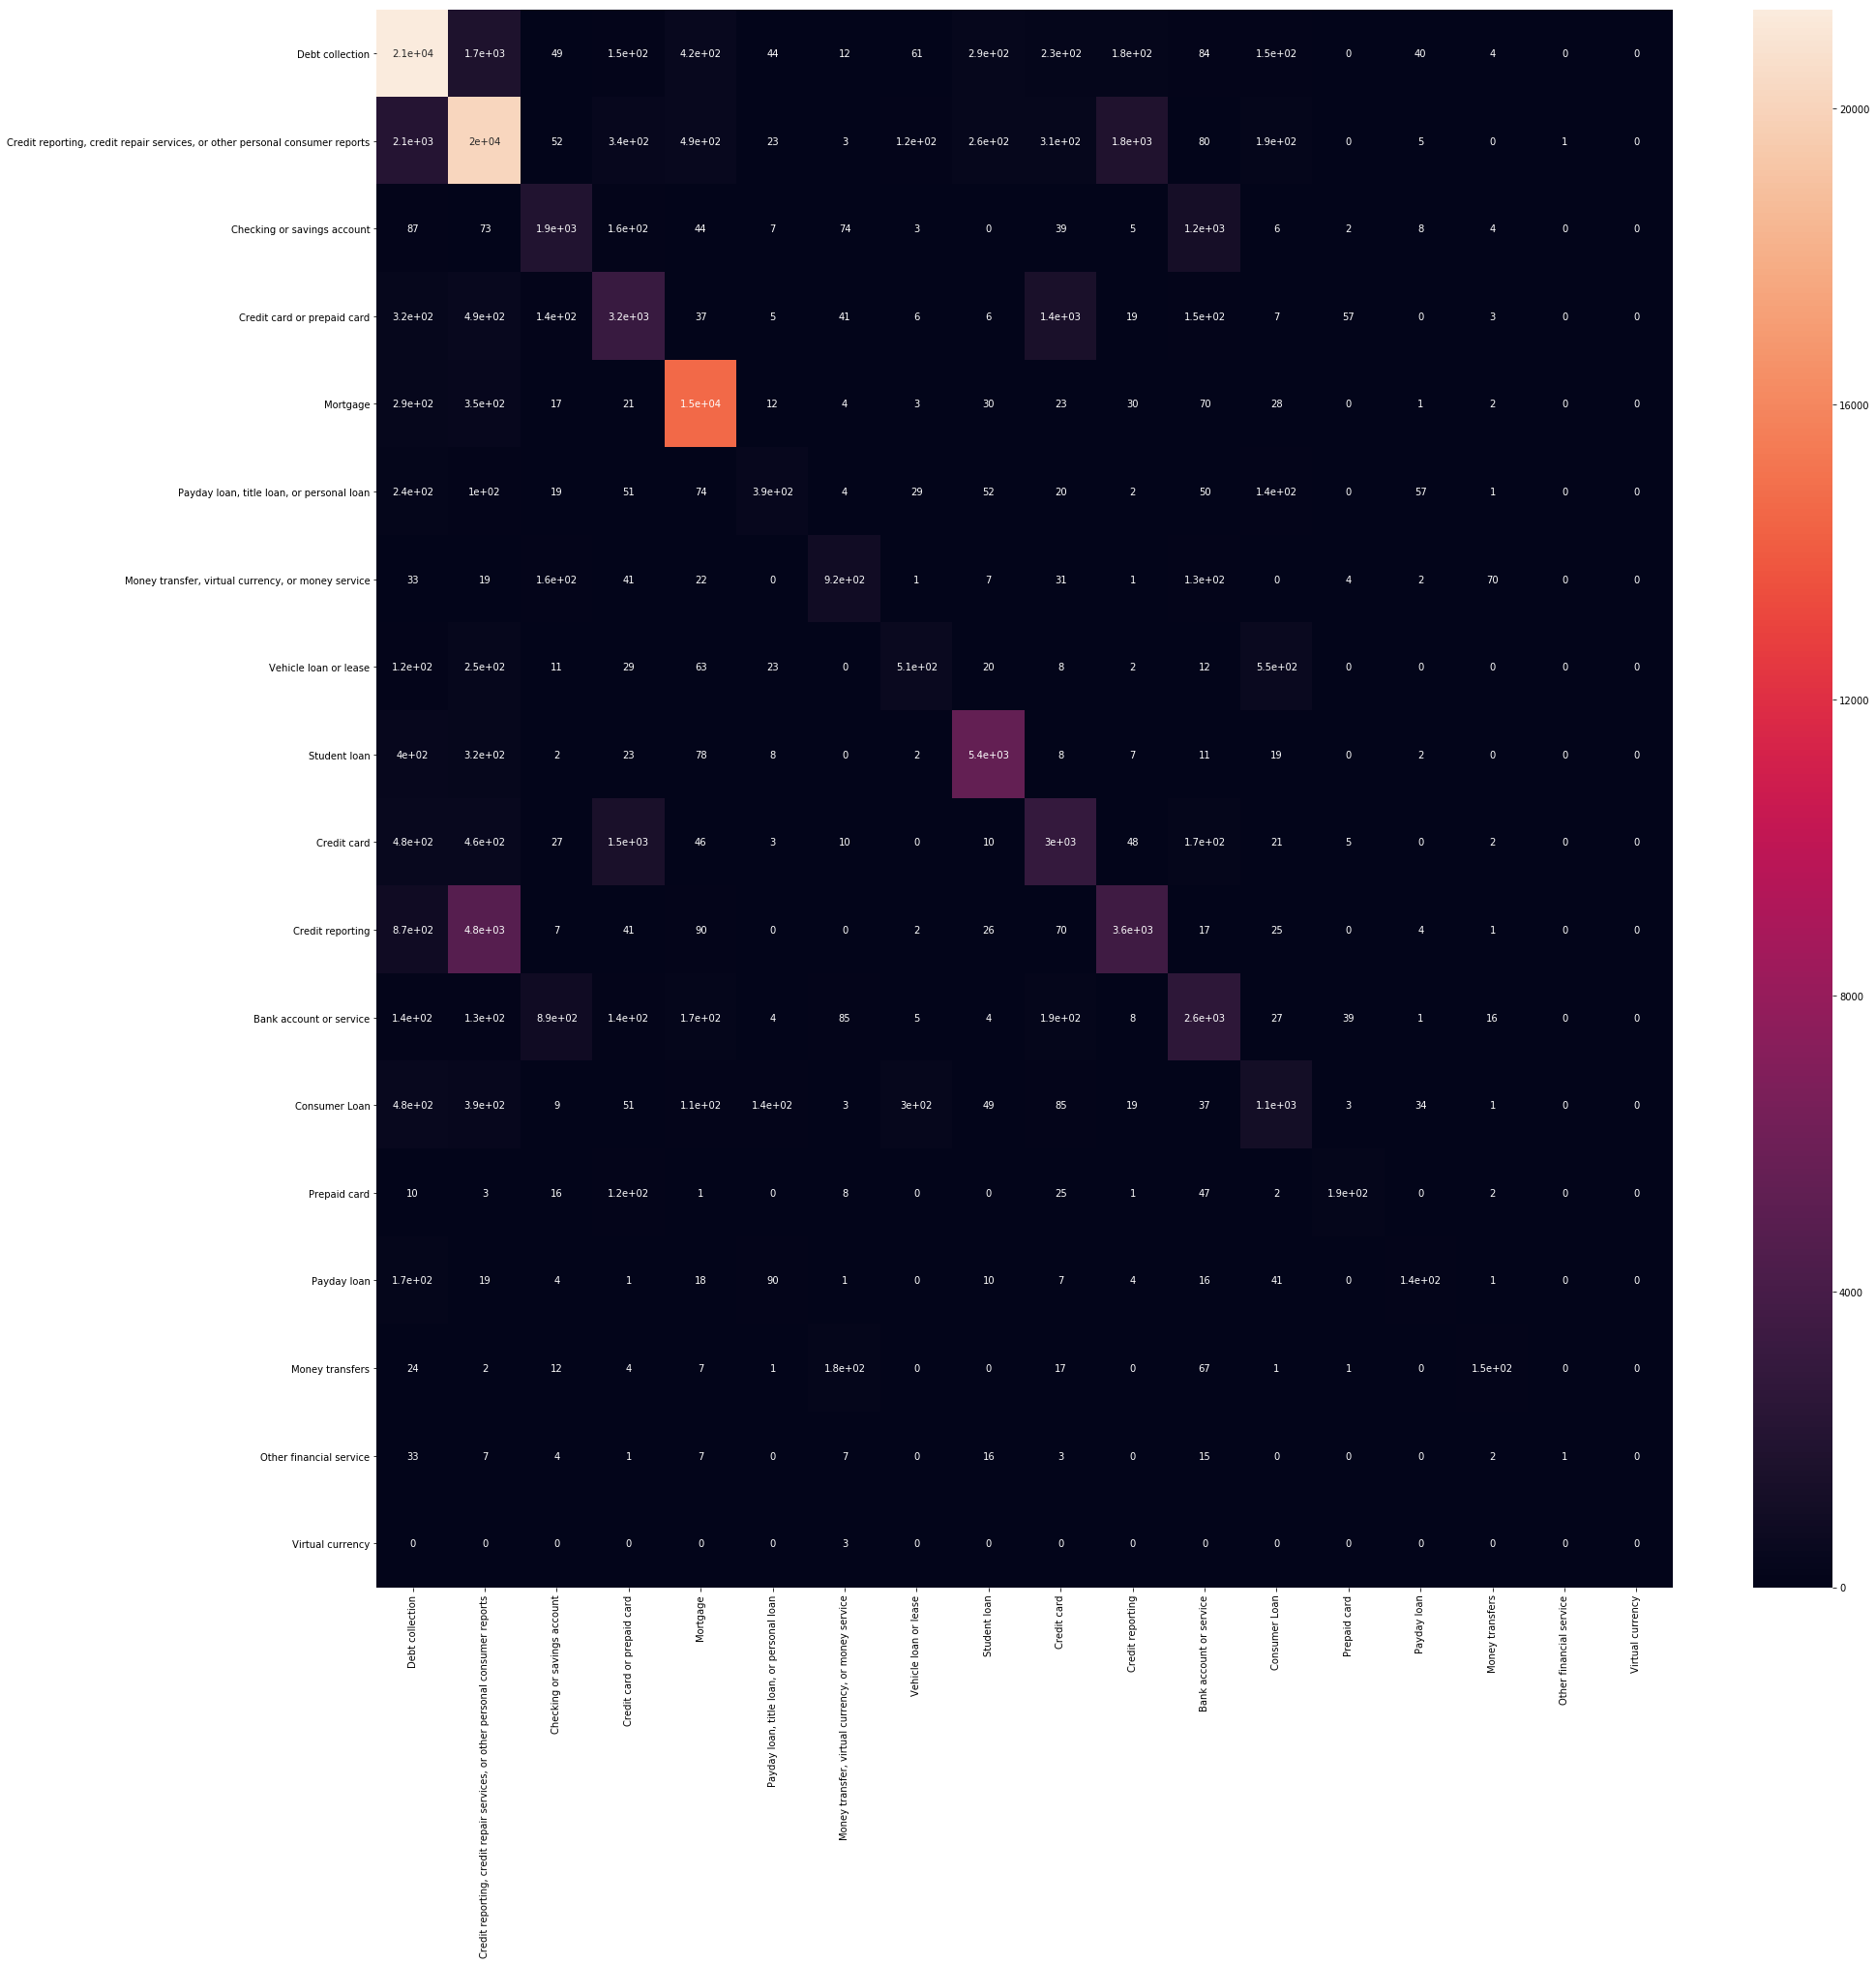

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(30,30))
sns.heatmap(cm_df,annot = True)

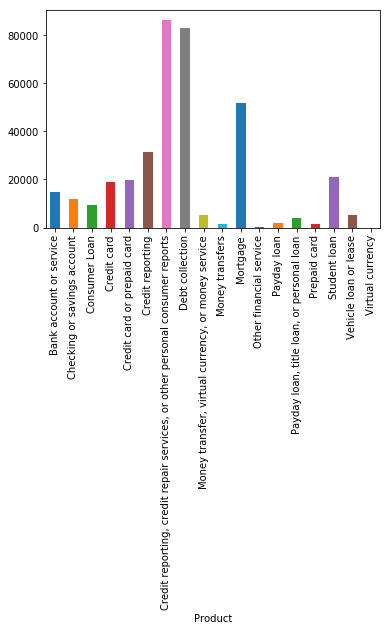

In [88]:
df1.groupby('Product')['Consumer complaint narrative'].count().plot.bar()

5. (Extra credit) Answer the questions in #4 for subproduct, issue-and sub-issue

### predicting subproduct

In [111]:
# prepare the dataframe for subproduct prediction by removing rows where subproduct is empty
df2 = df_dropped[df_dropped['Sub-product'].notna()]
# run sample
df2 = df2.sample(5000)

# create features and label variables
df2['Sub-product'] = df2['Sub-product'].astype('category')
df2['Sub-product_ID'] =df2['Sub-product'].factorize()[0]

narratives_2 = df2['Consumer complaint narrative'].tolist()
#products = df1['Product'].tolist()
labels_2 = df2['Sub-product_ID'].tolist()

# lemmatization
lemmatized_narratives_2 = []
for n in narratives_2:
    parsed_text = nlp(n)
    lemma_string = ''
    for token in parsed_text:
        lemma = token.lemma_.lower()
        if (re.match('[a-zA-Z]+$', lemma)) and not (nlp.vocab[lemma].is_stop):
            lemma_string += lemma+' '
    lemmatized_narratives_2.append(lemma_string)
    
# normalize the lemmas
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), norm = 'l2',max_df = 0.7,min_df = 5,sublinear_tf = True)
X_2 = vectorizer.fit_transform(lemmatized_narratives_2).toarray()
print (X_2.shape)

#split the data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,labels_2,test_size=0.3)

# train model
logreg = LogisticRegression(verbose=1, max_iter = 200, solver = 'saga', multi_class = 'multinomial')
clf_2 = logreg.fit(X_train_2,y_train_2)

# average accuracy
clf_2.score(X_test_2,y_test_2)

(5000, 14192)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 557 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min finished


0.42333333333333334

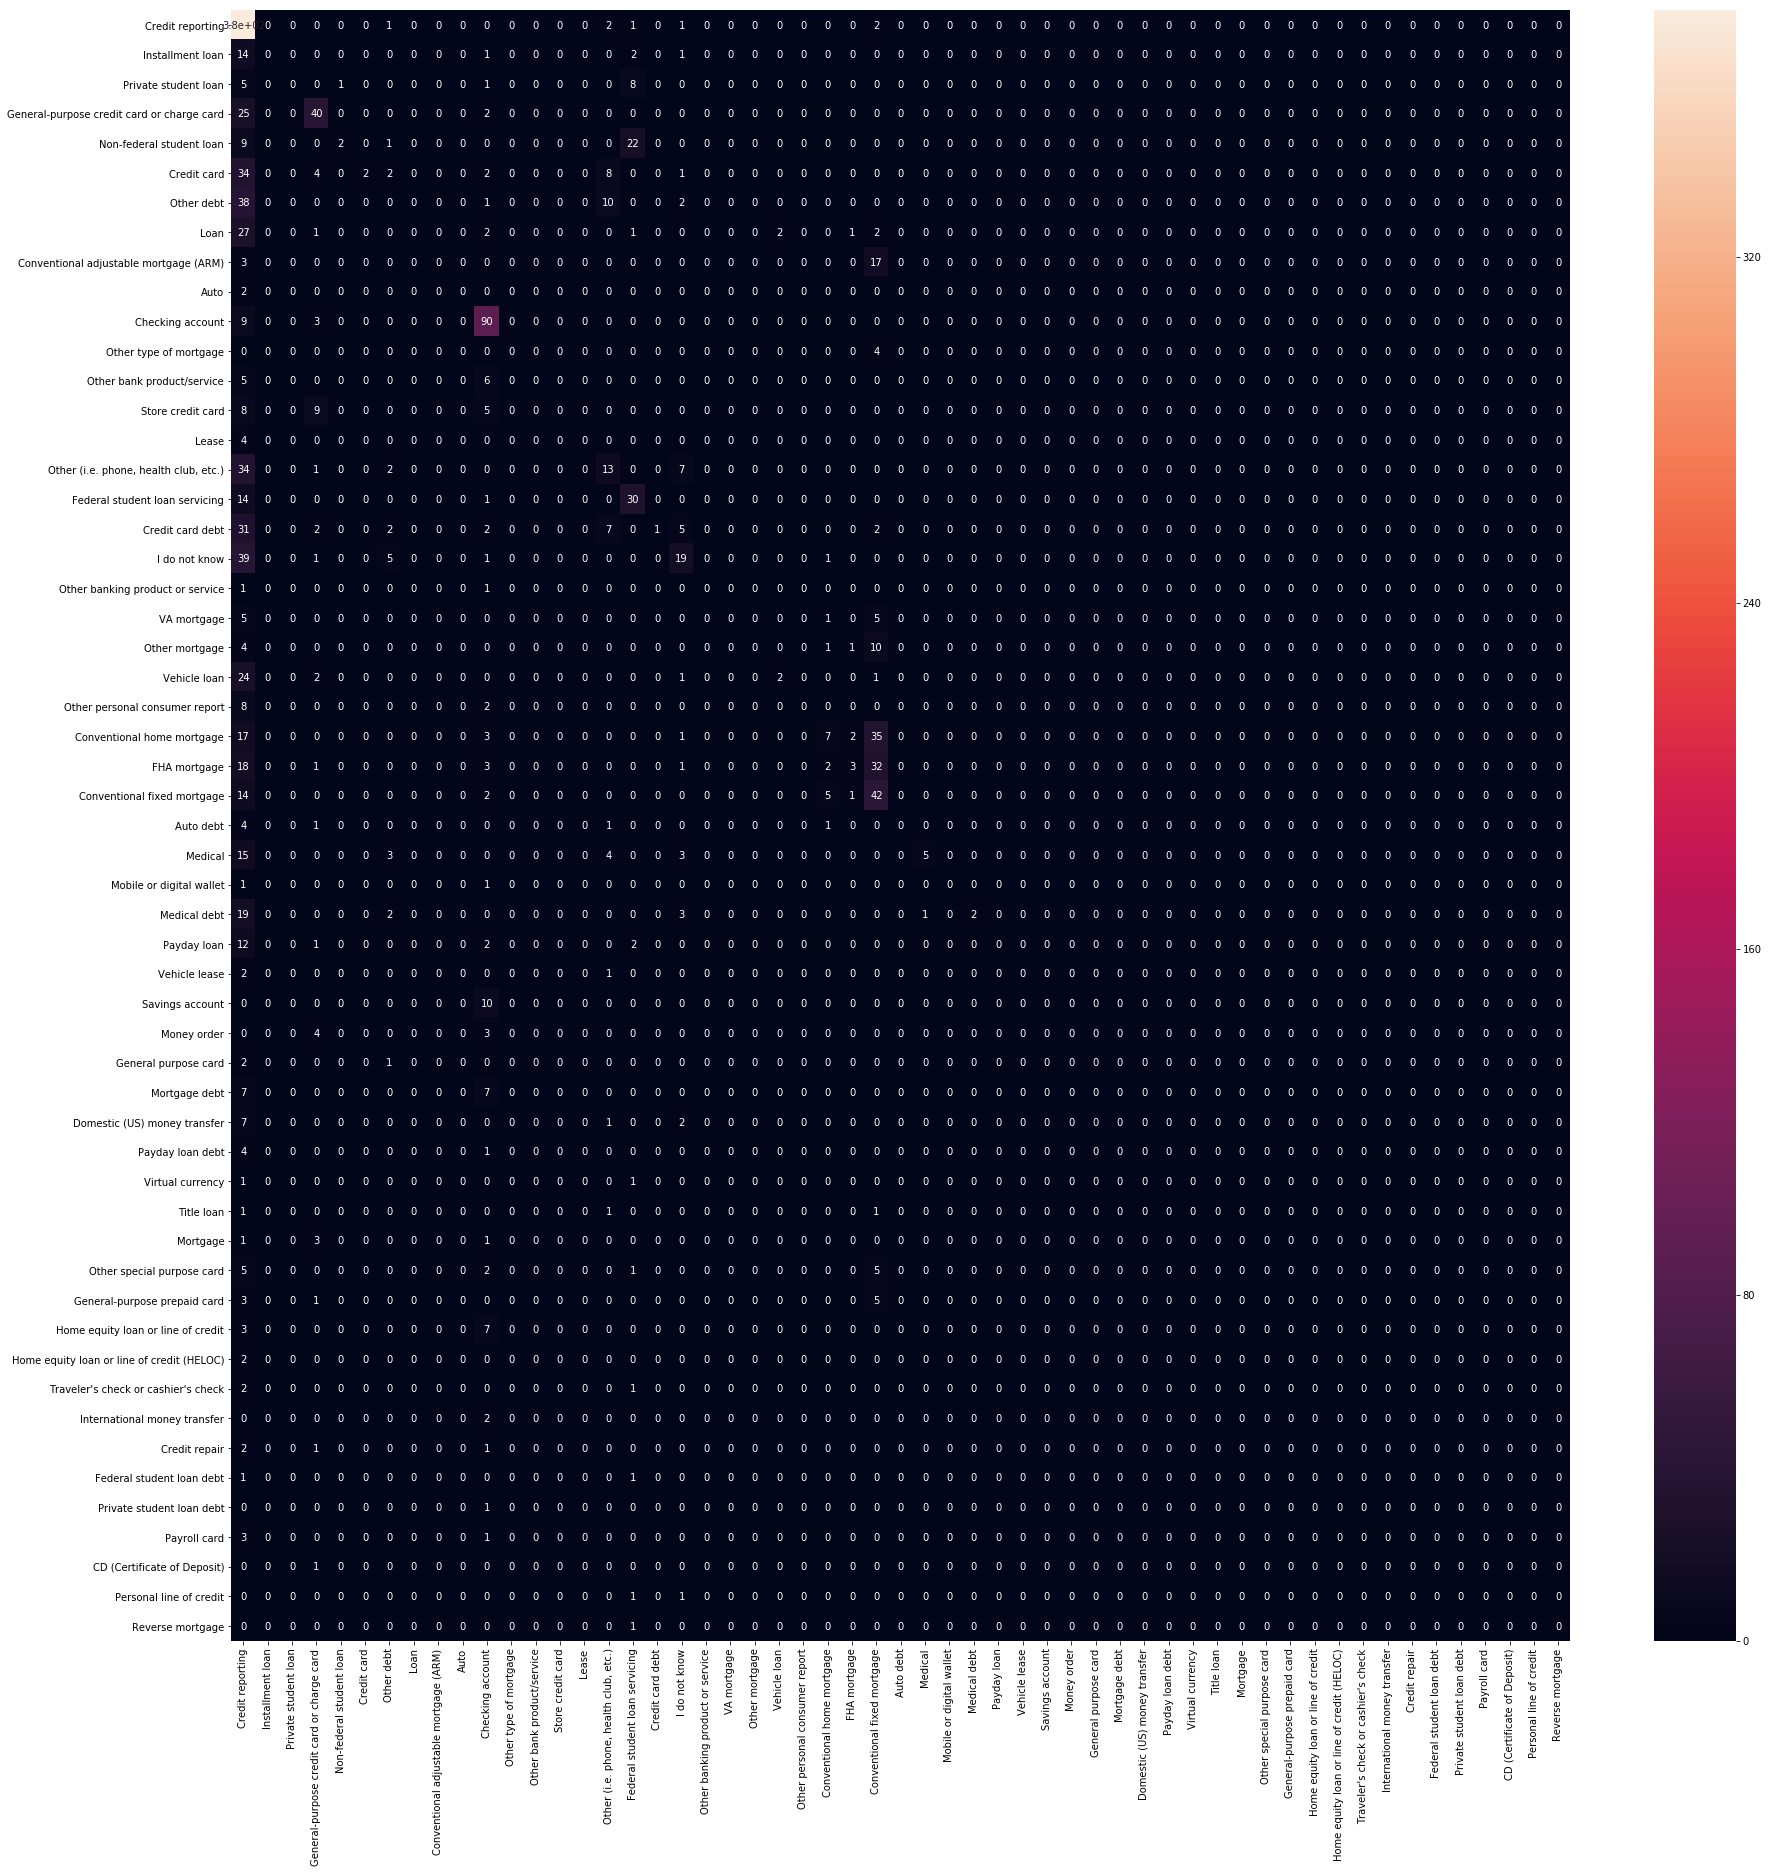

In [142]:
# plot confusion matrix
sub_product_list = df2[['Sub-product','Sub-product_ID']].drop_duplicates()\
.sort_values('Sub-product_ID')['Sub-product'].values

y_pred_2 = clf_2.predict(X_test_2)
conf_mat_2 = confusion_matrix(y_test_2, y_pred_2)
#the highest sub product id in y_test_2, y_pred_2 is 55
cm_df_2 = pd.DataFrame(conf_mat_2,index = sub_product_list[:55], columns = sub_product_list[:55])
plt.figure(figsize=(30,30))
sns.heatmap(cm_df_2,annot = True)

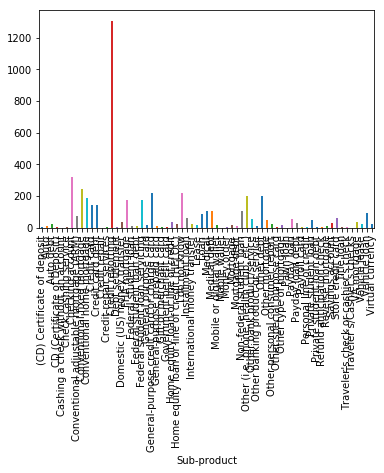

In [144]:
df2.groupby('Sub-product')['Consumer complaint narrative'].count().plot.bar()

From the accuracy score and the heatmap, we can see the complaints don't predict well about the sub-product. The best prediction is on the 'credit reporting' field, whereas there are few information about other fields presented in the matrix. After we examine the sample dataset of 5000, we can see most subgroups get around 200 complaints or much less. We don't have enough information about these groups to do a better prediction

### Predicting issues

In [ ]:
# prepare the dataframe for subproduct prediction by removing rows where subproduct is empty
df3 = df_dropped[df_dropped['Issue'].notna()]
# run sample
df3 = df3.sample(10000)

# create features and label variables
df3['Issue'] = df3['Issue'].astype('category')
df3['Issue_ID'] =df3['Issue'].factorize()[0]

narratives_3 = df3['Consumer complaint narrative'].tolist()
#products = df1['Product'].tolist()
labels_3 = df3['Issue_ID'].tolist()

# lemmatization - commented to improve the speed
#lemmatized_narratives_3 = []
#for n in narratives_3:
#    parsed_text = nlp(n)
#    lemma_string = ''
#    for token in parsed_text:
#        lemma = token.lemma_.lower()
#        if (re.match('[a-zA-Z]+$', lemma)) and not (nlp.vocab[lemma].is_stop):
#            lemma_string += lemma+' '
#    lemmatized_narratives_3.append(lemma_string)
    
# normalize the lemmas
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), norm = 'l2', stop_words = 'english',
                             max_df = 0.7,min_df = 5,sublinear_tf = True,max_features=1000)
X_3 = vectorizer.fit_transform(narratives_3).toarray()
print (X_3.shape)

#split the data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3,labels_3,test_size=0.3)

# train model
logreg = LogisticRegression(verbose=1, max_iter = 200, solver = 'saga', multi_class = 'multinomial')
clf_3 = logreg.fit(X_train_3,y_train_3)

# average accuracy
clf_3.score(X_test_3,y_test_3)

In [ ]:
# plot confusion matrix
issue_list = df3[['Issue','Issue_ID']].drop_duplicates()\
.sort_values('Issue_ID')['Issue'].values

y_pred_3 = clf_3.predict(X_test_3)
conf_mat_3 = confusion_matrix(y_test_3, y_pred_3)
#the highest sub product id in y_test_2, y_pred_2 is 55
cm_df_2 = pd.DataFrame(conf_mat_2)#,index = sub_product_list[:55], columns = sub_product_list[:55])
plt.figure(figsize=(30,30))
sns.heatmap(cm_df_2,annot = True)

### Predicting Subissues

In [ ]:
# prepare the dataframe for subproduct prediction by removing rows where subproduct is empty
df4 = df_dropped[df_dropped['Sub-issue'].notna()]
# run sample
df4 = df4.sample(10000)

# create features and label variables
df4['Sub-issue'] = df4['Sub-issue'].astype('category')
df4['Sub-issue_ID'] =df4['Sub-issue'].factorize()[0]

narratives_4 = df4['Consumer complaint narrative'].tolist()
#products = df1['Product'].tolist()
labels_4 = df4['Sub-issue_ID'].tolist()

# lemmatization
lemmatized_narratives_4 = []
for n in narratives_4:
    parsed_text = nlp(n)
    lemma_string = ''
    for token in parsed_text:
        lemma = token.lemma_.lower()
        if (re.match('[a-zA-Z]+$', lemma)) and not (nlp.vocab[lemma].is_stop):
            lemma_string += lemma+' '
    lemmatized_narratives_4.append(lemma_string)
    
# normalize the lemmas
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), norm = 'l2',
                             max_df = 0.7,min_df = 5,sublinear_tf = True,max_features = 1000)
X_4 = vectorizer.fit_transform(lemmatized_narratives_4).toarray()
print (X_4.shape)

#split the data
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4,labels_4,test_size=0.3)

# train model
logreg = LogisticRegression(verbose=1, max_iter = 200, solver = 'saga', 
                            multi_class = 'multinomial')
clf_4 = logreg.fit(X_train_4,y_train_4)

# average accuracy
clf_4.score(X_test_4,y_test_4)

In [ ]:
# plot confusion matrix
sub_issue_list = df4[['Sub_issue','Sub_issue_ID']].drop_duplicates()\
.sort_values('Sub_issue_ID')['Sub_issue'].values

y_pred_4 = clf_4.predict(X_test_4)
conf_mat_4 = confusion_matrix(y_test_4, y_pred_4)
cm_df_4 = pd.DataFrame(conf_mat_4)#,index = sub_product_list[:55], columns = sub_product_list[:55])
plt.figure(figsize=(30,30))
sns.heatmap(cm_df_4,annot = True)